How to create a Decision Tree classifer (and how to visualize it)
    


In [1]:
# Loading libraries
# Numpy is utilized to manipulate data containers
import numpy as np

# Matplotlib is used for visualizing the data with images
import matplotlib.pyplot as plt

# Sklearn is used to create classifiers
from sklearn import svm

In [2]:
# Loading the data recorded for the classes "walking" and "running"
# This loads the data into a NumPy array for further processing or analysis in Python
# The data is loaded into a "matrix" structure with two dimensions
walking_data = np.loadtxt("/notebooks/smartwearable2025/walking.csv", delimiter=",") 
running_data = np.loadtxt("/notebooks/smartwearable2025/running.csv", delimiter=",") 

In [3]:
# Let's have a look at the running data 
print("   ACC X,     ACC Y,   ACC Z,    GYRO X,   GYRO Y,    GYRO Z")
print(running_data)

   ACC X,     ACC Y,   ACC Z,    GYRO X,   GYRO Y,    GYRO Z
[[ 0.025326 -0.59752  -1.0327   -0.12104  -0.11972  -0.021759]
 [-1.02     -0.95089   0.52912  -0.053842  0.084916  0.031997]
 [ 0.79538   0.16032  -0.86596  -0.20411   0.35858  -0.28138 ]
 ...
 [ 1.374    -3.4229   11.3      -1.2851   -0.33533  -0.63586 ]
 [-0.74897  -1.8825    2.5919   -1.5704   -0.16444  -0.85288 ]
 [-0.91634  -1.5747   -0.37457  -0.84793  -0.013896 -0.63092 ]]


In [4]:
# Segmenting the data into sliding windows with overlap
window_length     = 50
window_step_size  = 25
num_channels      = 6

In [5]:
# Here we access the number of components in the first dimension (number of samples)
num_samples_walking = walking_data.shape[0]
num_samples_running = running_data.shape[0]

# Calculating the number of windows
# Note that // is the "floor division" operator. It is used for division where 
# the result is rounded down to the nearest whole number (integer)
num_windows_walking = (num_samples_walking - window_length) // window_step_size + 1
num_windows_running = (num_samples_running - window_length) // window_step_size + 1

print(f'Number of windows for class walking: {num_windows_walking}')
print(f'Number of windows for class running: {num_windows_running}')

Number of windows for class walking: 2449
Number of windows for class running: 1759


In [6]:
# Creating a 3D container (named tensor) to store the sliding windows
sliding_windows_walking = np.zeros((num_windows_walking, window_length, num_channels))
sliding_windows_running = np.zeros((num_windows_running, window_length, num_channels))

# Creating the sliding windows for both classes

for i in range(0, num_windows_walking):
    sliding_windows_walking[i, ...] = walking_data[i*window_step_size: i*window_step_size + window_length]
    
for i in range(0, num_windows_running):
    sliding_windows_running[i, ...] = running_data[i*window_step_size: i*window_step_size + window_length]

In [7]:
# Now let's define a function that will extract features from sliding window
# The input of the function is a sliding window
# The function outputs the features

# The features we will use: mean total acceleration and mean total angular speed (gyroscope reading)

# Be careful! Python starts counting from 0, not from 1

def extract_features_mean(sliding_window):
    total_acceleration = sliding_window[:, 0]**2 + sliding_window[:, 1]**2 + sliding_window[:, 2]**2
    total_angular_speed = sliding_window[:, 3]**2 + sliding_window[:, 4]**2 + sliding_window[:, 5]**2
    
    total_acceleration = np.sqrt(total_acceleration)
    total_angular_speed = np.sqrt(total_angular_speed)
    
    mean_total_acceleration = np.mean(total_acceleration)
    mean_total_angular_speed = np.mean(total_angular_speed)
    
    return mean_total_acceleration, mean_total_angular_speed

In [8]:
# Now that we have a function for extracting features, let's transform the sliding windows into features
num_features = 2
features_walking = np.zeros((num_windows_walking, num_features))
features_running = np.zeros((num_windows_running, num_features))

for i in range(0, num_windows_walking):
    mean_total_acceleration, mean_total_angular_speed = extract_features_mean(sliding_windows_walking[i, ...])
    features_walking[i, 0] = mean_total_acceleration
    features_walking[i, 1] = mean_total_angular_speed
    
for i in range(0, num_windows_running):
    mean_total_acceleration, mean_total_angular_speed = extract_features_mean(sliding_windows_running[i, ...])
    features_running[i, 0] = mean_total_acceleration
    features_running[i, 1] = mean_total_angular_speed

In [9]:
features_walking

array([[2.74706295, 0.45544902],
       [4.06025675, 0.54424592],
       [4.54472472, 0.59318349],
       ...,
       [2.21898633, 0.94433493],
       [2.53373546, 0.59593204],
       [2.88677307, 0.67659297]])

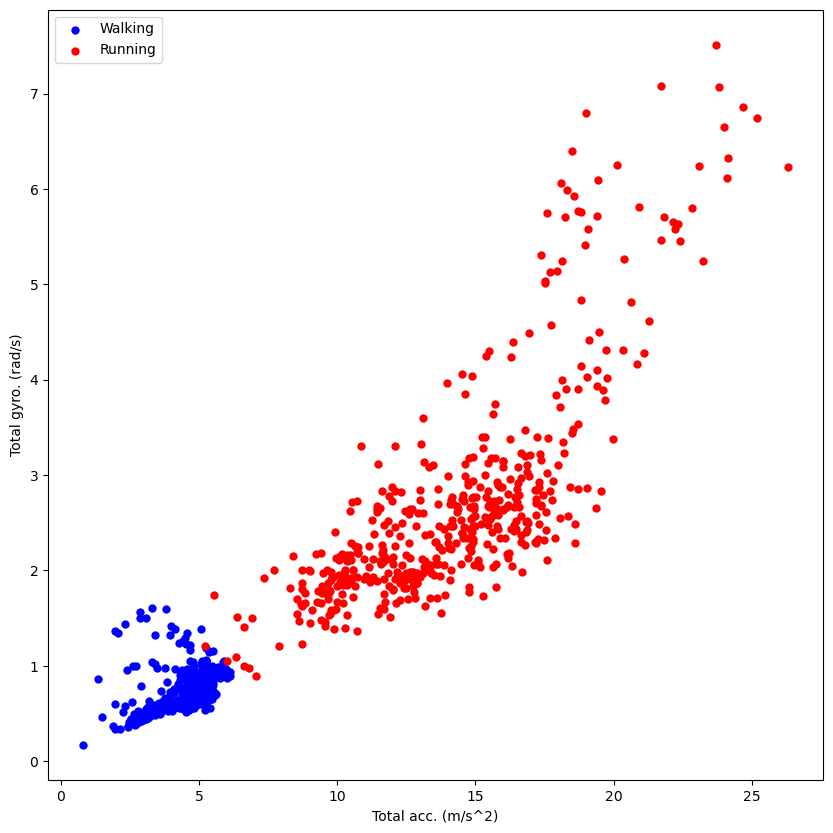

In [10]:
# Now let's visualize the features
plt.figure(figsize=(10,10))

# Let's only plot the first 500 components
plt.scatter(features_walking[:500, 0], features_walking[:500, 1],  linewidths=0.001, c = 'blue')
plt.scatter(features_running[:500, 0], features_running[:500, 1],  linewidths=0.001, c = 'red')

plt.xlabel("Total acc. (m/s^2)")
plt.ylabel("Total gyro. (rad/s)")

plt.legend(["Walking", "Running"])

In [11]:
# We now split the data into train, val and test sets based on percentages
train_portion = 0.70
val_portion   = 0.15

# Naturally, the remaining (0.15 or 15%) will be assigned to the test set
# Let's calculate how many windows will be assigned to each class and each set

num_windows_walking_train = int(num_windows_walking*train_portion)
num_windows_walking_val   = int(num_windows_walking*val_portion)
num_windows_walking_test  = num_windows_walking - num_windows_walking_train - num_windows_walking_val

num_windows_running_train = int(num_windows_running*train_portion)
num_windows_running_val   = int(num_windows_running*val_portion)
num_windows_running_test  = num_windows_running - num_windows_running_train - num_windows_running_val

In [12]:
# The function np.split splits the data at the points indicated in [num_windows_walking_train, num_windows_walking_train + num_windows_walking_val]
features_walking_train, features_walking_val, features_walking_test = np.split(features_walking, [num_windows_walking_train, num_windows_walking_train + num_windows_walking_val], axis = 0)
features_running_train, features_running_val, features_running_test = np.split(features_running, [num_windows_running_train, num_windows_running_train + num_windows_running_val], axis = 0)

In [13]:
# Now let's put together the data of the two classes and create an array that indicates their labels (identifiers 0 and 1 for walking and running, respectively)
X_train = np.concatenate([features_walking_train, features_running_train], axis = 0)
Y_train = np.concatenate([np.zeros(num_windows_walking_train), np.ones(num_windows_running_train)])

X_val   = np.concatenate([features_walking_val, features_running_val], axis = 0)
Y_val   = np.concatenate([np.zeros(num_windows_walking_val), np.ones(num_windows_running_val)])

X_test  = np.concatenate([features_walking_test, features_running_test], axis = 0)
Y_test  = np.concatenate([np.zeros(num_windows_walking_test), np.ones(num_windows_running_test)])

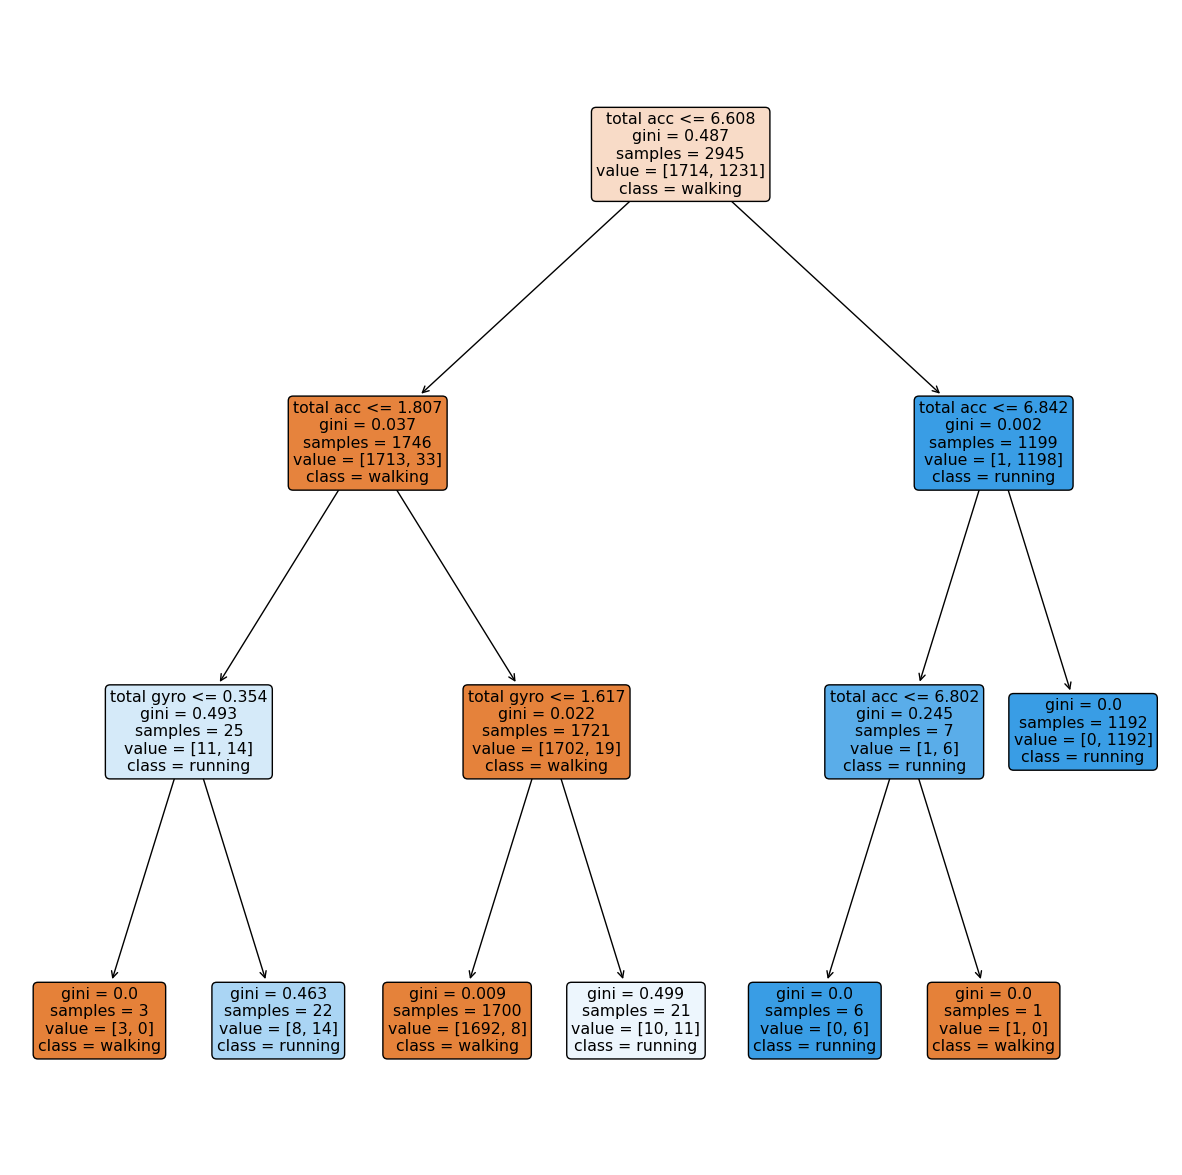

Validation accuracy for the decision tree: 96.98412698412699


In [14]:
# Let's import decision trees from sklearn
from sklearn import tree

plt.figure(figsize=(15, 15) )
# Decision Tree classifier
clf_tree = tree.DecisionTreeClassifier(max_depth = 3)
clf_tree = clf_tree.fit(X_train, Y_train)
    
tree.plot_tree(clf_tree, filled = True, feature_names = ["total acc", "total gyro"], class_names = ["walking", "running"], rounded = True)
plt.show()
validation_acc = clf_tree.score(X_val, Y_val)*100
print(f'Validation accuracy for the decision tree: {validation_acc}')